This notebook uses a new version of NaMaster (respect to the previous notebooks)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
from scipy import stats
import common as co
import flatmaps as fm
import healpy as hp
import numpy as np
import pymaster as nmt
import os

In [3]:
prefix =  'run_low_noise_ee_bb'
run_path = os.path.join('./simulations_outputs/', prefix, prefix)
figures_dir = os.path.join('./simulations_outputs/', prefix, 'figures')
if not os.path.isdir(figures_dir):
    os.makedirs(figures_dir)
fig_run_path = os.path.join(figures_dir, prefix)
data_folder = './data/'
sims_suffix = '_clsims_0001-20000.npz'
nside=512 # I think it can be read from somewhere

# Common

## Load theoretical data and sampled data

In [4]:
clTh = np.loadtxt(os.path.join(data_folder, "cls_lss.txt"), unpack=True)
lTh = clTh[0] # [:3*512]
clTh_TT = (clTh[1] + clTh[5])  # [:3*512]
clTh_EE = (clTh[2] + 1e-2 * clTh[6])  # [:3*512]    ###### Recall to multiply it by 1e-2
clTh_BB = (clTh[3] + 1e-2 * clTh[7])  # [:3*512]    ###### Recall to multiply it by 1e-2
clTh_TE = (clTh[4] + clTh[-1]) # [:3*512]
clTh_TB = clTh_EB = np.zeros(len(clTh_TE))
# l,cltt,clee,clbb,clte,nltt,nlee,nlbb,nlte=np.loadtxt("data/cls_lss.txt",unpack=True)
# cltt[0]=0; clee[0]=0; clbb[0]=0; clte[0]=0;
# nltt[0]=0; nlee[0]=0; nlbb[0]=0; nlte[0]=0;

In [5]:
clsims = np.load(run_path + sims_suffix)

In [6]:
fmi,mask_hsc=fm.read_flat_map("data/mask_lss_flat.fits")
fsky=np.sum(mask_hsc * np.radians(fmi.dx) * np.radians(fmi.dy)) / (4 * np.pi)

# Used later for naive cov and to generate fields.
ell_min=max(2*np.pi/fmi.lx_rad,2*np.pi/fmi.ly_rad)
ell_max=min(fmi.nx*np.pi/fmi.lx_rad,fmi.ny*np.pi/fmi.ly_rad)
d_ell=2*ell_min
n_ell=int((ell_max-ell_min)/d_ell)-1
l_bpw=np.zeros([2,n_ell])
l_bpw[0,:]=ell_min+np.arange(n_ell)*d_ell
l_bpw[1,:]=l_bpw[0,:]+d_ell
b=nmt.NmtBinFlat(l_bpw[0,:],l_bpw[1,:])

if not os.path.isfile(run_path + '_ells.txt'):
    np.savetxt(run_path + '_ells.txt', b.get_effective_ells())

In [7]:
def get_fields(fsk,mask,w_cont=False) :
    """
    Generate a simulated field.
    It returns two NmtField objects for a spin-0 and a spin-2 field.

    :param fsk: a fm.FlatMapInfo object.
    :param mask: a sky mask.
    :param w_cont: deproject any contaminants? (not implemented yet)
    """
    st,sq,su=nmt.synfast_flat(int(fsk.nx),int(fsk.ny),fsk.lx_rad,fsk.ly_rad,
                              [clTh_TT, clTh_TE, clTh_TB, clTh_EE, clTh_EB, clTh_BB], [0,2])
    if w_cont :
        if np.any(templates_all):
            tst, tsq, tsu = templates_all.sum(axis=0)
            st+=tst; sq+=tsq; su+=tsu;
        if o.no_deproject :
            ff0=nmt.NmtFieldFlat(fsk.lx_rad,fsk.ly_rad,mask.reshape([fsk.ny,fsk.nx]),
                                 [st])
            ff2=nmt.NmtFieldFlat(fsk.lx_rad,fsk.ly_rad,mask.reshape([fsk.ny,fsk.nx]),
                                 [sq, su])
        else :
            ff0=nmt.NmtFieldFlat(fsk.lx_rad,fsk.ly_rad,mask.reshape([fsk.ny,fsk.nx]),
                                 [st],
                                 templates=templates_all[:,0,None,:])
            ff2=nmt.NmtFieldFlat(fsk.lx_rad,fsk.ly_rad,mask.reshape([fsk.ny,fsk.nx]),
                                 [sq,su],
                                 templates=templates_all[:,1:, :])
    else :
        ff0=nmt.NmtFieldFlat(fsk.lx_rad,fsk.ly_rad,mask.reshape([fsk.ny,fsk.nx]),
                             [st])
        ff2=nmt.NmtFieldFlat(fsk.lx_rad,fsk.ly_rad,mask.reshape([fsk.ny,fsk.nx]),
                             [sq,su])
    return ff0,ff2

np.random.seed(1000)
f0,f2=get_fields(fmi,mask_hsc, 'contaminants' in prefix)

### Simulations correlations

In [8]:
clTT = cl00 = np.reshape(clsims['cl00'], np.array(np.shape(clsims['cl00']))[[0,2]])
clTB = clsims['cl02'][:,1,:]
clTE = clsims['cl02'][:,0,:]
clEE = clsims['cl22'][:,0,:]
clEB = clsims['cl22'][:,1,:]
clBB = clsims['cl22'][:,3,:]
nlbins = len(clTT[0])
lbins = clsims['l']

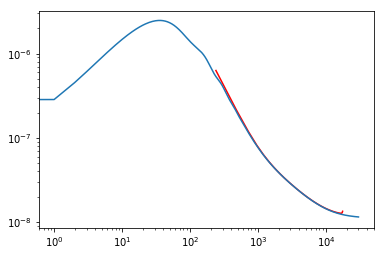

In [9]:
plt.plot(clsims['l'],np.mean(clTT,axis=0),'r-')
plt.plot(lTh,clTh_TT)
plt.loglog()
plt.show()
plt.close()

Healpix has bins of same area but its integrals are not completely exact. Sometimes the best we can do is up to (2 x nbins)

In [10]:
lmax = len(lbins) # (clsims['l'] < 2*512).sum()

In [11]:
CovSims_path = run_path + '_cov'+sims_suffix
if os.path.isfile(CovSims_path):
    C = np.load(CovSims_path)['arr_0']
else:
    C = np.cov(np.concatenate([clTT.T, clTE.T, clTB.T, clEE.T, clEB.T, clBB.T]))
    np.savez_compressed(CovSims_path, C)
C = C.reshape((6, nlbins, 6, nlbins))

In [12]:
CovSims_TT = C[0, :, 0, :]
CovSims_TE = C[1, :, 1, :]
CovSims_TB = C[2, :, 2, :]
CovSims_EE = C[3, :, 3, :]
CovSims_EB = C[4, :, 4, :]
CovSims_BB = C[5, :, 5, :]

CovSims_TTTE = C[0, :, 1, :]
CovSims_TTTB = C[0, :, 2, :]
CovSims_TTEE = C[0, :, 3, :]
CovSims_TTEB = C[0, :, 4, :]
CovSims_TTBB = C[0, :, 4, :]

CovSims_TETB = C[1, :, 2, :]
CovSims_TEEE = C[1, :, 3, :]
CovSims_TEEB = C[1, :, 4, :]
CovSims_TEBB = C[1, :, 5, :]

CovSims_TBEE = C[2, :, 3, :]
CovSims_TBEB = C[2, :, 4, :]
CovSims_TBBB = C[2, :, 5, :]

CovSims_EEEB = C[3, :, 4, :]
CovSims_EEBB = C[3, :, 5, :]

CovSims_EBBB = C[4, :, 5, :]

if os.path.isfile(run_path + '_covTTTEEE'+sims_suffix):
    CovSims_TTTEEE = np.load(run_path + '_covTTTEEE'+sims_suffix)['arr_0']
else:
    CovSims_TTTEEE = np.block([[CovSims_TT, CovSims_TTTE, CovSims_TTEE], 
                               [CovSims_TTTE.T, CovSims_TE, CovSims_TEEE], 
                               [CovSims_TTEE.T, CovSims_TEEE.T, CovSims_EE]])
    np.savez_compressed(run_path + '_covTTTEEE'+sims_suffix, CovSims_TTTEEE)

### Analytic Covariances

In [13]:
w00 = nmt.NmtWorkspaceFlat()
w00.read_from(run_path + "_w00.dat")
w02 = nmt.NmtWorkspaceFlat()
w02.read_from(run_path + "_w02.dat")
w22 = nmt.NmtWorkspaceFlat()
w22.read_from(run_path + "_w22.dat")

We don't need to create a different covariance workspace for each spin combination because it only depends on the masks of the field

In [14]:
cw = nmt.NmtCovarianceWorkspaceFlat()

if os.path.isfile(run_path + '_cw.dat'):
    cw.read_from(run_path + '_cw.dat')
else: 
    cw.compute_coupling_coefficients(f0, f0, b)
    cw.write_to(run_path + '_cw.dat')

#### Approx Efstathiou

In [15]:
cltt = clTh_TT
clte = clTh_TE
clee = clTh_EE
clbb = clTh_BB

if os.path.isfile(run_path+'_c0000.npz'):
    c0000 = np.load(run_path+'_c0000.npz')['arr_0']
else:
    c0000=nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltt],[cltt],[cltt],[cltt],w00); print(c0000.shape)
    np.savez_compressed(run_path+'_c0000.npz', c0000)
    
if os.path.isfile(run_path+'_c0002.npz'):
    c0002 = np.load(run_path+'_c0002.npz')['arr_0']
else:
    c0002=nmt.gaussian_covariance_flat(cw,0,0,0,2,lTh,[cltt],[clte,0*clte],[cltt],[clte,0*clte],w00,w02).reshape((nlbins, 1, nlbins, 2)); print(c0002.shape)
    np.savez_compressed(run_path+'_c0002.npz', c0002)
    
if os.path.isfile(run_path+'_c0022.npz'):
    c0022 = np.load(run_path+'_c0022.npz')['arr_0']
else:
    c0022=nmt.gaussian_covariance_flat(cw,0,0,2,2,lTh,[clte,0*clte],[clte,0*clte],[clte,0*clte],[clte,0*clte],w00,w22).reshape((nlbins, 1, nlbins, 4)); print(c0022.shape)
    np.savez_compressed(run_path+'_c0022.npz', c0022)
    
if os.path.isfile(run_path+'_c0202.npz'):
    c0202 = np.load(run_path+'_c0202.npz')['arr_0']
else:
    c0202=nmt.gaussian_covariance_flat(cw,0,2,0,2,lTh,[cltt],[clte,0*clte],[clte,0*clte],[clee,0*clee,0*clbb,clbb],w02,w02).reshape((nlbins, 2, nlbins, 2)); print(c0202.shape)
    np.savez_compressed(run_path+'_c0202.npz', c0202)
    
if os.path.isfile(run_path+'_c0222.npz'):
    c0222 = np.load(run_path+'_c0222.npz')['arr_0']
else:
    c0222=nmt.gaussian_covariance_flat(cw,0,2,2,2,lTh,[clte,0*clte],[clte,0*clte],[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],w02,w22).reshape((nlbins, 2, nlbins, 4)); print(c0222.shape)
    np.savez_compressed(run_path+'_c0222.npz', c0222)
    
if os.path.isfile(run_path+'_c2222.npz'):
    c2222 = np.load(run_path+'_c2222.npz')['arr_0']
else:
    c2222=nmt.gaussian_covariance_flat(cw,2,2,2,2,lTh,[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],w22,w22).reshape((nlbins, 4, nlbins, 4)); print(c2222.shape)
    np.savez_compressed(run_path+'_c2222.npz', c2222)
    
    
# c0020=nmt.gaussian_covariance_flat(cw,0,0,2,0,[clte,0*clte],[cltt],[clte,0*clte],[cltt],w00,w02); print(c0020.shape)
#c0200=nmt.gaussisloan_covariance_flat(cw,0,2,0,0,[cltt],[cltt],[clte,0*clte],[clte,0*clte],w02,w00); print(c0200.shape)
#c0220=nmt.gaussian_covariance_flat(cw,0,2,2,0,[clte,0*clte],[cltt],[clee,0*clee,0*clbb,clbb],[clte,0*clte],w02,w02); print(c0220.shape)
#c2000=nmt.gaussian_covariance_flat(cw,2,0,0,0,[clte,0*clte],[clte,0*clte],[cltt],[cltt],w02,w00); print(c2000.shape)
#c2002=nmt.gaussian_covariance_flat(cw,2,0,0,2,[clte,0*clte],[clee,0*clee,0*clbb,clbb],[cltt],[clte,0*clte],w02,w02); print(c2002.shape)
#c2020=nmt.gaussian_covariance_flat(cw,2,0,2,0,[clee,0*clee,0*clbb,clbb],[clte,0*clte],[clte,0*clte],[cltt],w02,w02); print(c2020.shape)
#c2022=nmt.gaussian_covariance_flat(cw,2,0,2,2,[clee,0*clee,0*clbb,clbb],[clee,0*clee,0*clbb,clbb],[clte,0*clte],[clte,0*clte],w02,w22); print(c2022.shape)
#c2200=nmt.gaussian_covariance_flat(cw,2,2,0,0,[clte,0*clte],[clte,0*clte],[clte,0*clte],[clte,0*clte],w22,w00); print(c2200.shape)
#c2202=nmt.gaussian_covariance_flat(cw,2,2,0,2,[clte,0*clte],[clee,0*clee,0*clbb,clbb],[clte,0*clte],[clee,0*clee,0*clbb,clbb],w22,w02); print(c2202.shape)
#c2220=nmt.gaussian_covariance_flat(cw,2,2,2,0,[clee,0*clee,0*clbb,clbb],[clte,0*clte],[clee,0*clee,0*clbb,clbb],[clte,0*clte],w22,w02); print(c2220.shape)

CovTh_TT = c0000
CovTh_TTTE, CovTh_TTTB = c0002[:, 0, :, [0, 1]]
CovTh_TTEE, CovTh_TTEB, CovTh_TTBE, CovTh_TTBB = c0022[:, 0, :, [0, 1, 2, 3]]
CovTh_TETE, CovTh_TETB = c0202[:, 0, :, [0, 1] ]
CovTh_TBTE, CovTh_TBTB = c0202[:, 1, :, [0, 1] ]
CovTh_TEEE, CovTh_TEEB, CovTh_TEBE, CovTh_TEBB =  c0222[:, 0, :, [0, 1, 2, 3] ]
CovTh_TBEE, CovTh_TBEB, CovTh_TBBE, CovTh_TBBB = c0222[:, 1, :, [0, 1, 2, 3] ]
CovTh_EEEE, CovTh_EEEB, CovTh_EEBE, CovTh_EEBB = c2222[:, 0, :, [0, 1, 2, 3] ]
CovTh_EBEE, CovTh_EBEB, CovTh_EBBE, CovTh_EBBB = c2222[:, 1, :, [0, 1, 2, 3] ]
CovTh_BEEE, CovTh_BEEB, CovTh_BEBE, CovTh_BEBB = c2222[:, 2, :, [0, 1, 2, 3] ]
CovTh_BBEE, CovTh_BBEB, CovTh_BBBE, CovTh_BBBB = c2222[:, 3, :, [0, 1, 2, 3] ]

CovTh_TE = CovTh_TETE
CovTh_TB = CovTh_TBTB
CovTh_EE = CovTh_EEEE
CovTh_EB = CovTh_EBEB
CovTh_BB = CovTh_BBBB

if os.path.isfile(run_path + '_covThTTTEEE.npz'):
    CovTh_TTTEEE = np.load(run_path + '_covThTTTEEE.npz')['arr_0']
else:
    CovTh_TTTEEE = np.block([[CovTh_TT, CovTh_TTTE, CovTh_TTEE], 
                               [CovTh_TTTE.T, CovTh_TE, CovTh_TEEE], 
                               [CovTh_TTEE.T, CovTh_TEEE.T, CovTh_EE]])
    np.savez_compressed(run_path + '_covThTTTEEE.npz', CovTh_TTTEEE)

(73, 73)
(73, 1, 73, 2)
(73, 1, 73, 4)
(73, 2, 73, 2)
(73, 2, 73, 4)
(73, 4, 73, 4)


In [16]:
len(lTh)

30000

#### Spin 2 ~ Spin 0

In [17]:
cltt = clTh_TT
clte = clTh_TE
cltb = clbe = 0 * cltt
clee = clTh_EE
cleb = clbe = 0 * clee
clbb = clTh_BB

CovTh0_TT = CovTh_TT
CovTh0_TE = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltt],[clte],[clte],[clee],w00)
CovTh0_TB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltt],[cltb],[cltb],[clbb],w00)
CovTh0_EE = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clee],[clee],[clee],[clee],w00)
CovTh0_EB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clee],[cleb],[cleb],[clbb],w00)
CovTh0_BB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clbb],[clbb],[clbb],[clbb],w00)

CovTh0_TTTE = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltt],[clte],[cltt],[clte],w00)
CovTh0_TTTB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltt],[cltb],[cltt],[cltb],w00)
CovTh0_TTEE = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[clte],[clte],[clte],w00)
CovTh0_TTEB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[cltb],[clte],[cltb],w00)
CovTh0_TTBB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltb],[cltb],[cltb],[cltb],w00)

CovTh0_TETB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltt],[cltb],[clte],[cleb],w00)
CovTh0_TEEE = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[clte],[clee],[clee],w00)
CovTh0_TEEB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[cltb],[clee],[cleb],w00)
CovTh0_TEBB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltb],[cltb],[cleb],[cleb],w00)

CovTh0_TBEE = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[clte],[clbe],[clbe],w00)
CovTh0_TBEB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clte],[cltb],[clbe],[clbb],w00)
CovTh0_TBBB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cltb],[cltb],[clbb],[clbb],w00)

CovTh0_EEEB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[clee],[cleb],[clee],[cleb],w00)
CovTh0_EEBB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cleb],[cleb],[cleb],[cleb],w00)

CovTh0_EBBB = nmt.gaussian_covariance_flat(cw,0,0,0,0,lTh,[cleb],[clbb],[cleb],[clbb],w00)

#### Naive approx

In [18]:
ell_min=max(2*np.pi/fmi.lx_rad,2*np.pi/fmi.ly_rad)
ell_max=min(fmi.nx*np.pi/fmi.lx_rad,fmi.ny*np.pi/fmi.ly_rad)
d_ell=2*ell_min
n_ell=int((ell_max-ell_min)/d_ell)-1
l_bpw=np.zeros([2,n_ell])
l_bpw[0,:]=ell_min+np.arange(n_ell)*d_ell
l_bpw[1,:]=l_bpw[0,:]+d_ell
CovThN_TT = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clTh_TT, clTh_TT, clTh_TT, clTh_TT)
CovThN_TE = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clTh_TT, clTh_TE, clTh_TE, clTh_EE)
CovThN_TB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clTh_TT, clTh_TB, clTh_TB, clTh_BB)
CovThN_EE = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clTh_EE, clTh_EE, clTh_EE, clTh_EE)
CovThN_EB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clTh_EE, clTh_EB, clTh_EB, clTh_BB)
CovThN_BB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clTh_BB, clTh_BB, clTh_BB, clTh_BB)

CovThN_TTTE = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltt, clte, cltt, clte)
CovThN_TTTB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltt, cltb, cltt, cltb)
CovThN_TTEE = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, clte, clte, clte)
CovThN_TTEB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, cltb, clte, cltb)
CovThN_TTBB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltb, cltb, cltb, cltb)

CovThN_TETB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltt, cltb, clte, cleb)
CovThN_TEEE = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, clte, clee, clee)
CovThN_TEEB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, cltb, clee, cleb)
CovThN_TEBB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltb, cltb, cleb, cleb)

CovThN_TBEE = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, clte, clbe, clbe)
CovThN_TBEB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clte, cltb, clbe, clbb)
CovThN_TBBB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cltb, cltb, clbb, clbb)

CovThN_EEEB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, clee, cleb, clee, cleb)
CovThN_EEBB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cleb, cleb, cleb, cleb)

CovThN_EBBB = co.naive_covariance(lTh, l_bpw[0,:], l_bpw[1,:], fsky, cleb, clbb, cleb, clbb)

# Efstathiou approximation

In [19]:
foutput = fig_run_path + '_Efstathiou'

## TTTT

Checks for TTTT
Diagonal covariance matrix


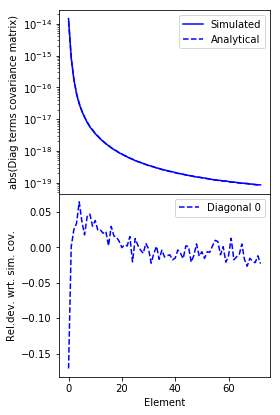

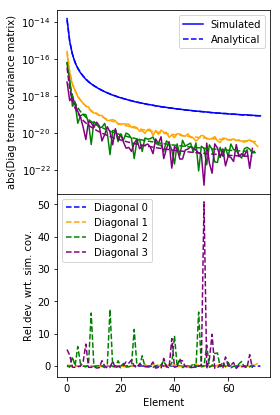

Chi2 distribution check


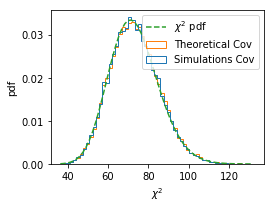

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.007850000000000024, pvalue=0.5671609413723806)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.005277688190870766, pvalue=0.6332676026783453)
KS between th. and chi2 distributions:  KstestResult(statistic=0.00932691059292945, pvalue=0.061634559304228405)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.007172159936613021, pvalue=0.2549888471890028)

Difference between analytic and sims. correlation matrix


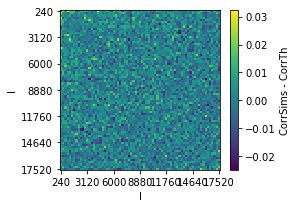

Eigenvalues vs l


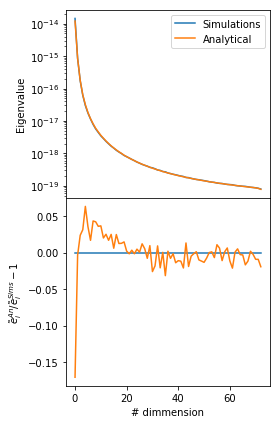

Row of cov. matrix.


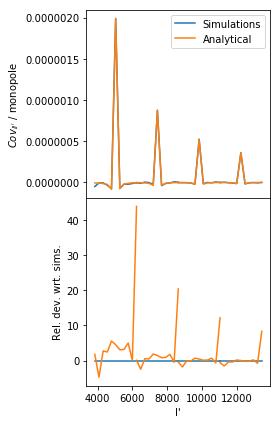

In [20]:
chi2_TTTT, corr_TTTT = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TT[:lmax, :lmax], CovTh_TT[:lmax, :lmax],
                                        modes="TTTT", foutput=foutput + '_TTTT')

In [21]:
from scipy.special import gammaln
from scipy.integrate import quad
from scipy.interpolate import interp1d
import scipy.stats as stats
def chi2_dist_t(chi2, n, dof):
    """
    Eq. 20 from 1511.05969 (Sellentin)
    param n: N - 1, with N the number of simulations
    param dof: number of l's in cov matrix.
    """
    p = dof
    
    g = gammaln((n+1)/2) - gammaln((n-p+1)/2) - gammaln(p/2)
    num = - p/2*np.log(n) + (p/2-1) * np.log(chi2)
    den = (n+1)/2 * np.log(chi2/n + 1)
    
    return np.exp(g + num - den)

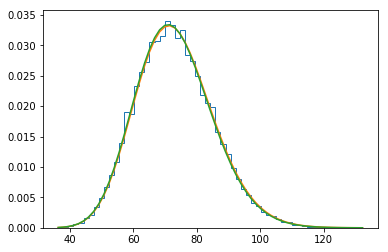

In [22]:
h, x, _ = plt.hist(chi2_TTTT[0], histtype='step', bins=60, density=True)  #  , clTT.shape[0])))


df = CovSims_TT.shape[0]
p = df

Y = chi2_dist_t(x, clTT.shape[0] - 1, df)

plt.plot(x, chi2_dist_t(x, clTT.shape[0] - 1, df))
plt.plot(x, stats.chi2.pdf(x, df=df))
plt.show()
plt.close()

## TETE

Checks for TETE
Diagonal covariance matrix


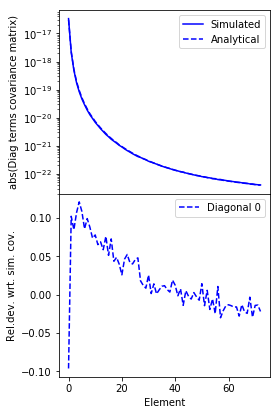

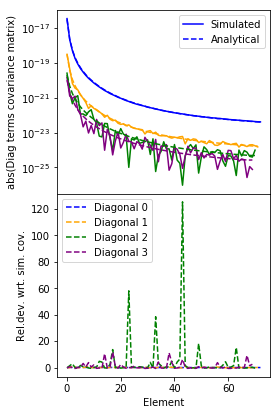

Chi2 distribution check


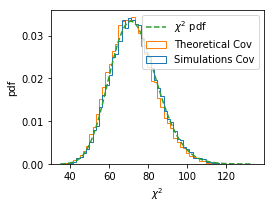

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.04620000000000002, pvalue=5.207027053790449e-19)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004147378353762887, pvalue=0.8816027037904001)
KS between th. and chi2 distributions:  KstestResult(statistic=0.04593362381578314, pvalue=4.4499094486112725e-37)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.0043448603628089555, pvalue=0.8445821184489765)

Difference between analytic and sims. correlation matrix


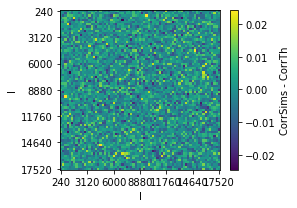

Eigenvalues vs l


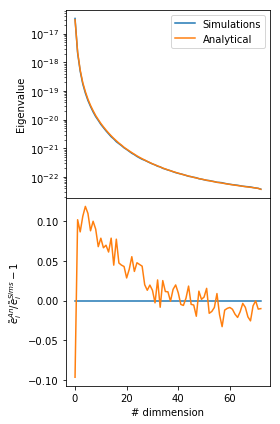

Row of cov. matrix.


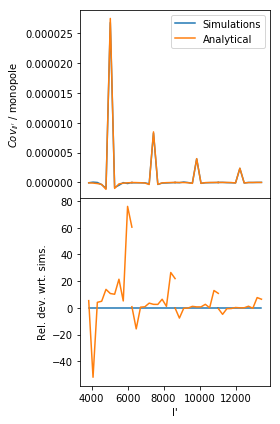

In [23]:
chi2_TETE, corr_TETE = co.do_all_checks(lbins[:lmax], clTE[:, :lmax], CovSims_TE[:lmax, :lmax], CovTh_TETE[:lmax, :lmax],
                                        modes="TETE", foutput=foutput + '_TETE')

## EEEE

Checks for EEEE
Diagonal covariance matrix


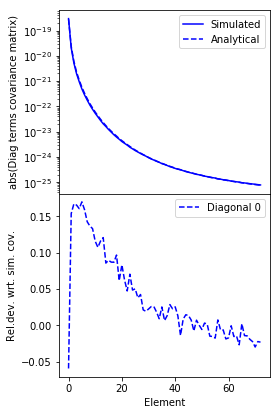

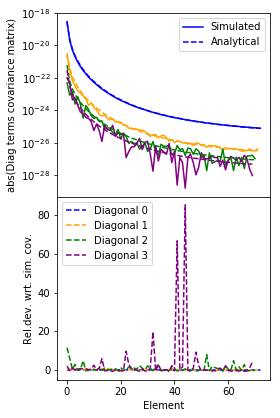

Chi2 distribution check


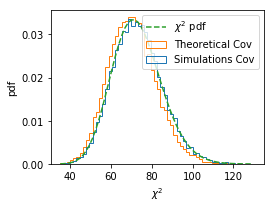

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.08265, pvalue=6.663918490976521e-60)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0057857890668666645, pvalue=0.514780560481503)
KS between th. and chi2 distributions:  KstestResult(statistic=0.07750465131441253, pvalue=8.897256138755645e-105)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.0055445235079211175, pvalue=0.5701919792801683)

Difference between analytic and sims. correlation matrix


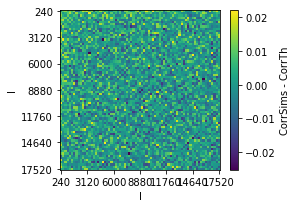

Eigenvalues vs l


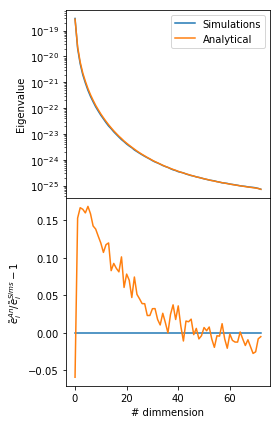

Row of cov. matrix.


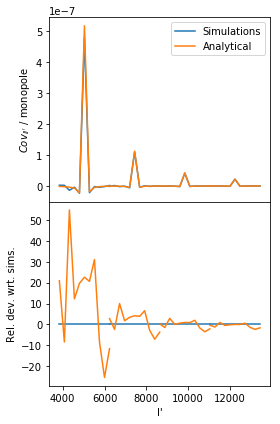

In [24]:
chi2_EEEE, corr_EEEE = co.do_all_checks(lbins[:lmax], clEE[:, :lmax], CovSims_EE[:lmax, :lmax], CovTh_EEEE[:lmax, :lmax],
                                        modes="EEEE", foutput=foutput + '_EEEE')

## BBBB

Checks for BBBB
Diagonal covariance matrix


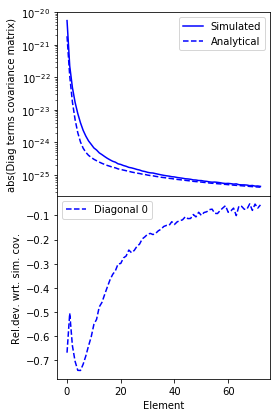

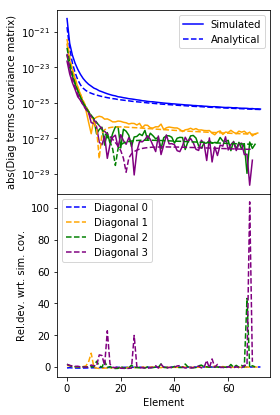

Chi2 distribution check


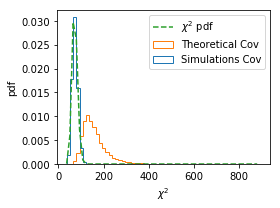

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.91315, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.006850539350129137, pvalue=0.30494086300747525)
KS between th. and chi2 distributions:  KstestResult(statistic=0.9138481623845736, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.006994410796082484, pvalue=0.281802422418032)

Difference between analytic and sims. correlation matrix


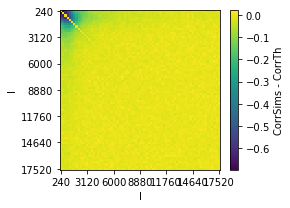

Eigenvalues vs l


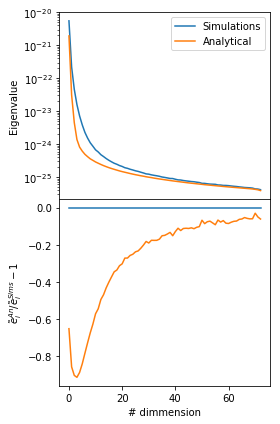

Row of cov. matrix.


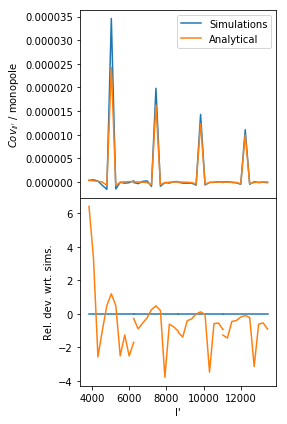

In [25]:
chi2_BBBB, corr_BBBB = co.do_all_checks(lbins[:lmax], clBB[:, :lmax], CovSims_BB[:lmax, :lmax], CovTh_BBBB[:lmax, :lmax],
                                        modes="BBBB", foutput=foutput + '_BBBB')

## TBTB

Checks for TBTB
Diagonal covariance matrix


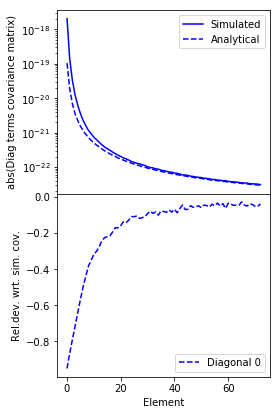

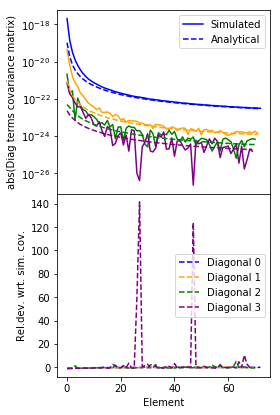

Chi2 distribution check


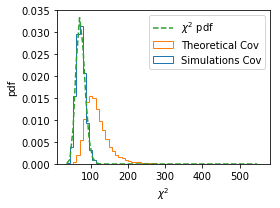

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.72645, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0041333214150549025, pvalue=0.8840676131235339)
KS between th. and chi2 distributions:  KstestResult(statistic=0.7266272015111688, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.007260296324331783, pvalue=0.24241099075692585)

Difference between analytic and sims. correlation matrix


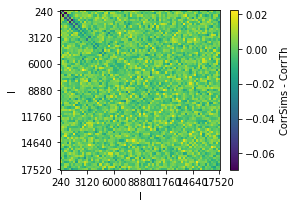

Eigenvalues vs l


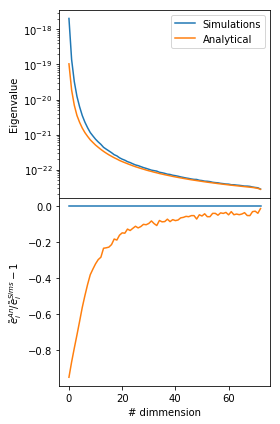

Row of cov. matrix.


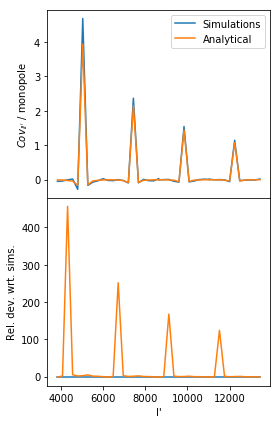

In [26]:
chi2_TBTB, corr_TBTB = co.do_all_checks(lbins[:lmax], clTB[:, :lmax], CovSims_TB[:lmax, :lmax], CovTh_TBTB[:lmax, :lmax],
                                        modes="TBTB", foutput=foutput + '_TBTB')

## EBEB

Checks for EBEB
Diagonal covariance matrix


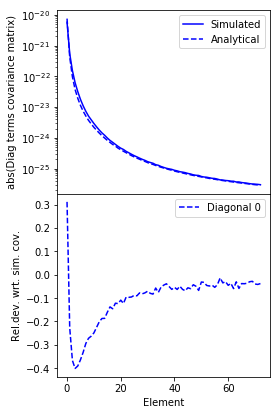

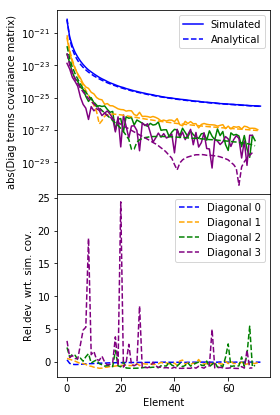

Chi2 distribution check


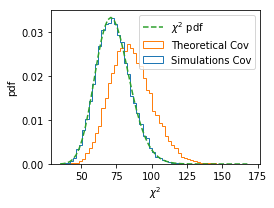

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.35125000000000006, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0058138795748926, pvalue=0.5084707606792822)
KS between th. and chi2 distributions:  KstestResult(statistic=0.34972195719927734, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.007996500908955595, pvalue=0.15488396022677453)

Difference between analytic and sims. correlation matrix


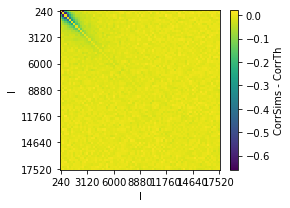

Eigenvalues vs l


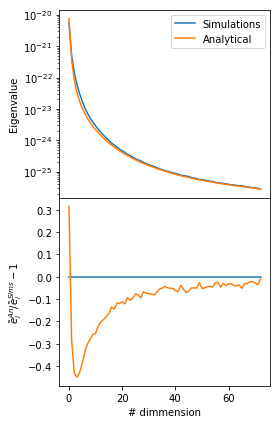

Row of cov. matrix.


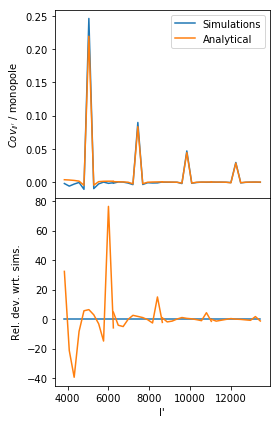

In [27]:
chi2_EBEB, corr_EBEB = co.do_all_checks(lbins[:lmax], clEB[:, :lmax], CovSims_EB[:lmax, :lmax], CovTh_EBEB[:lmax, :lmax],
                                        modes="EBEB", foutput=foutput + '_EBEB')

# Spin0 approximation

In [28]:
foutput = fig_run_path + '_spin0app'

## TTTT

Checks for TTTT
Diagonal covariance matrix


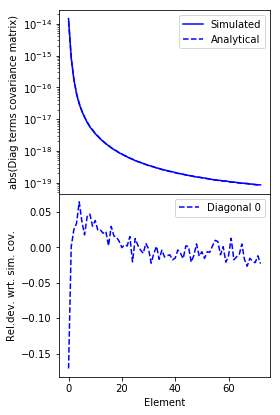

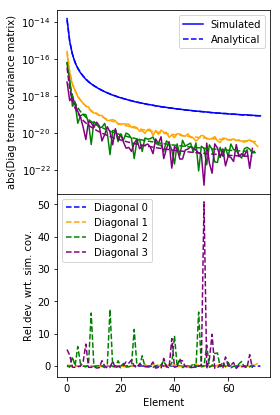

Chi2 distribution check


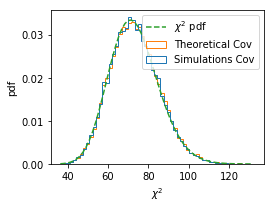

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.007850000000000024, pvalue=0.5671609413723806)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.005277688190870766, pvalue=0.6332676026783453)
KS between th. and chi2 distributions:  KstestResult(statistic=0.00932691059292945, pvalue=0.061634559304228405)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.006635340683974533, pvalue=0.34196382505510936)

Difference between analytic and sims. correlation matrix


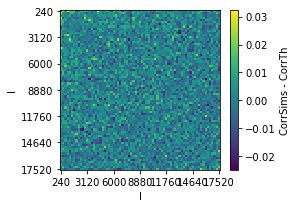

Eigenvalues vs l


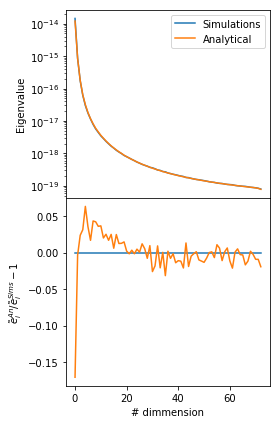

Row of cov. matrix.


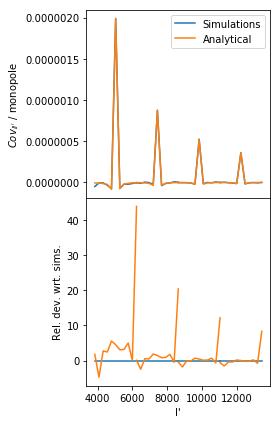

In [29]:
chi20_TTTT, corr0_TTTT = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TT[:lmax, :lmax], CovTh0_TT[:lmax, :lmax],
                                          modes="TTTT", foutput=foutput + '_TTTT')

## TETE

Checks for TETE
Diagonal covariance matrix


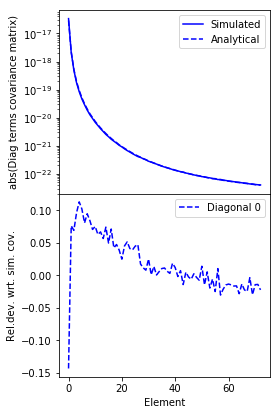

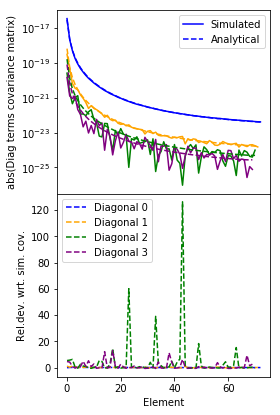

Chi2 distribution check


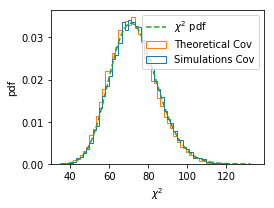

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.039650000000000074, pvalue=4.098777496091529e-14)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004147378353762887, pvalue=0.8816027037904001)
KS between th. and chi2 distributions:  KstestResult(statistic=0.03972330044848582, pvalue=7.751650927375512e-28)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.006518165801326248, pvalue=0.3633326961115975)

Difference between analytic and sims. correlation matrix


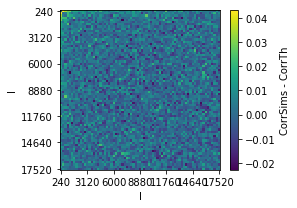

Eigenvalues vs l


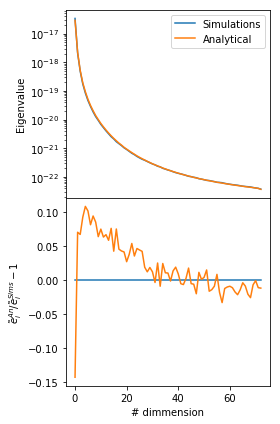

Row of cov. matrix.


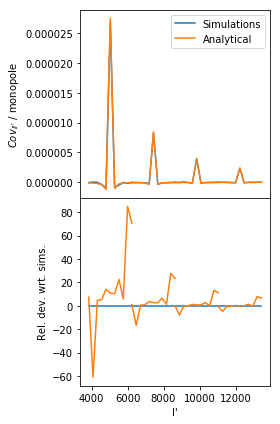

In [30]:
chi20_TETE, corr0_TETE = co.do_all_checks(lbins[:lmax], clTE[:, :lmax], CovSims_TE[:lmax, :lmax], CovTh0_TE[:lmax, :lmax],
                                          modes="TETE", foutput=foutput + '_TETE')

## EEEE

Checks for EEEE
Diagonal covariance matrix


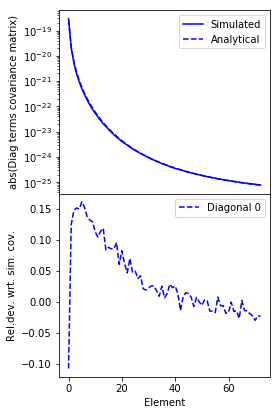

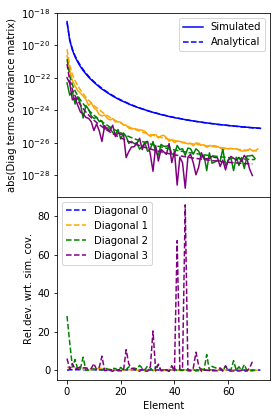

Chi2 distribution check


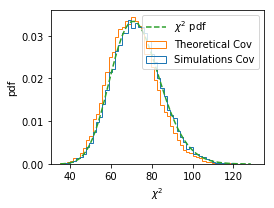

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.07455, pvalue=8.136731944824743e-49)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0057857890668666645, pvalue=0.514780560481503)
KS between th. and chi2 distributions:  KstestResult(statistic=0.06927218222612408, pvalue=8.713606568216717e-84)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.005726423876159348, pvalue=0.5282210751543668)

Difference between analytic and sims. correlation matrix


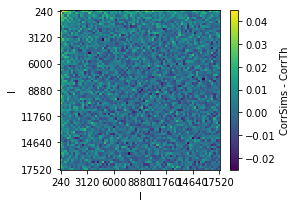

Eigenvalues vs l


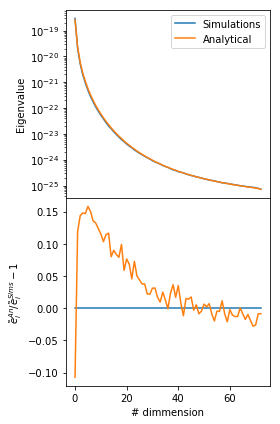

Row of cov. matrix.


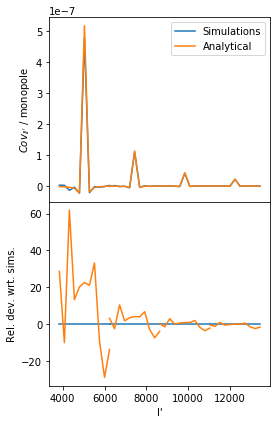

In [31]:
chi20_EEEE, corr0_EEEE = co.do_all_checks(lbins[:lmax], clEE[:, :lmax], CovSims_EE[:lmax, :lmax], CovTh0_EE[:lmax, :lmax],
                                          modes="EEEE", foutput=foutput + '_EEEE')

## BBBB

Checks for BBBB
Diagonal covariance matrix


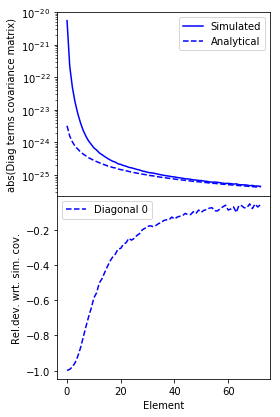

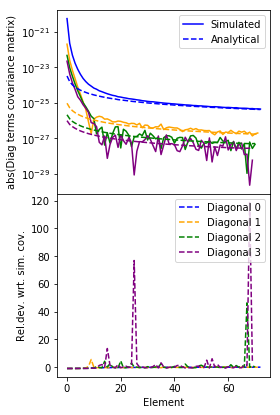

Chi2 distribution check


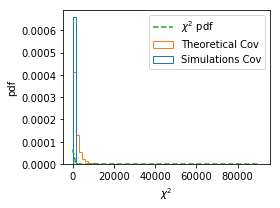

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.99675, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.006850539350129137, pvalue=0.30494086300747525)
KS between th. and chi2 distributions:  KstestResult(statistic=0.996771744947495, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.00589746533775537, pvalue=0.4898979739062386)

Difference between analytic and sims. correlation matrix


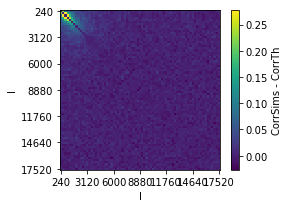

Eigenvalues vs l


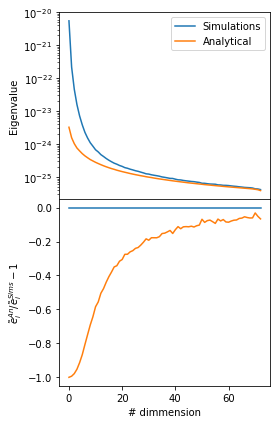

Row of cov. matrix.


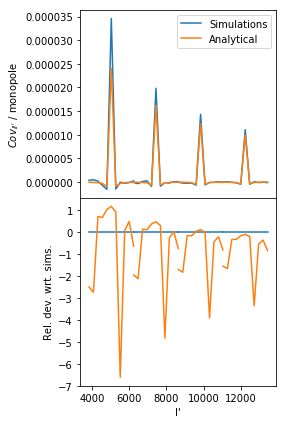

In [32]:
chi20_BBBB, corr0_BBBB = co.do_all_checks(lbins[:lmax], clBB[:, :lmax], CovSims_BB[:lmax, :lmax], CovTh0_BB[:lmax, :lmax],
                                          modes="BBBB", foutput=foutput + '_BBBB')

## TBTB

Checks for TBTB
Diagonal covariance matrix


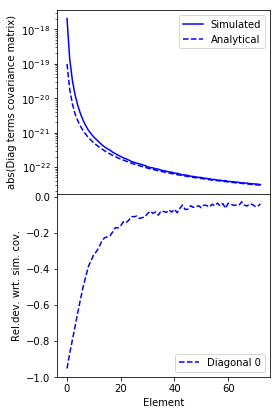

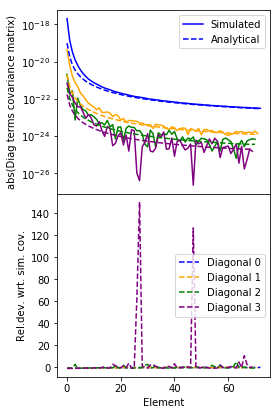

Chi2 distribution check


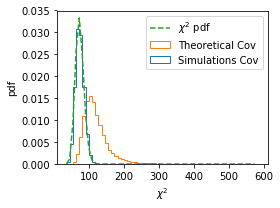

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.7342000000000001, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0041333214150549025, pvalue=0.8840676131235339)
KS between th. and chi2 distributions:  KstestResult(statistic=0.7342288627015178, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.0036714704889533323, pvalue=0.9503017815962889)

Difference between analytic and sims. correlation matrix


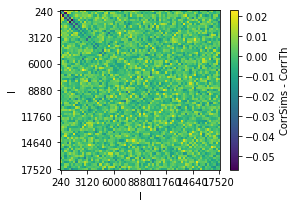

Eigenvalues vs l


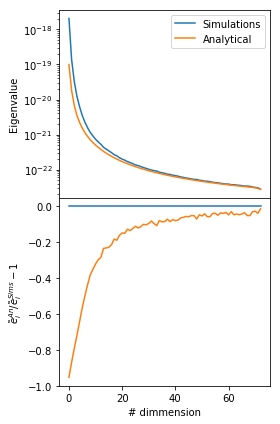

Row of cov. matrix.


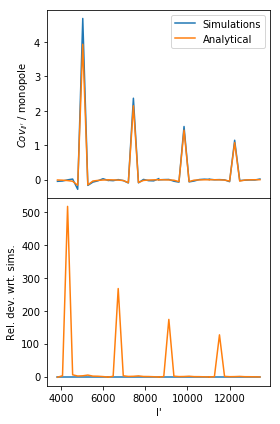

In [33]:
chi20_TBTB, corr0_TBTB = co.do_all_checks(lbins[:lmax], clTB[:, :lmax], CovSims_TB[:lmax, :lmax], CovTh0_TB[:lmax, :lmax],
                                          modes="TBTB", foutput=foutput + '_TBTB')

## EBEB

Checks for EBEB
Diagonal covariance matrix


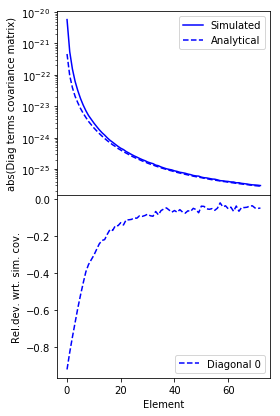

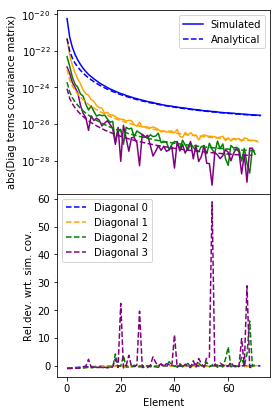

Chi2 distribution check


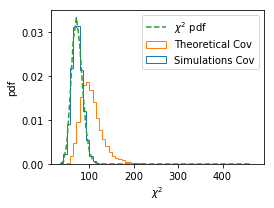

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.62805, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0058138795748926, pvalue=0.5084707606792822)
KS between th. and chi2 distributions:  KstestResult(statistic=0.6295997102995536, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.00460246857460378, pvalue=0.7906374593069161)

Difference between analytic and sims. correlation matrix


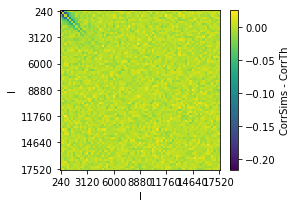

Eigenvalues vs l


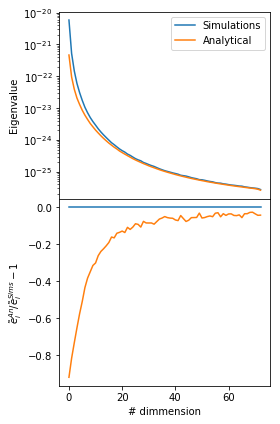

Row of cov. matrix.


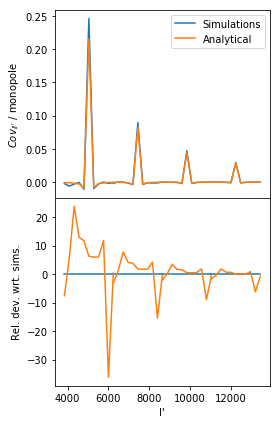

In [34]:
chi20_EBEB, corr0_EBEB = co.do_all_checks(lbins[:lmax], clEB[:, :lmax], CovSims_EB[:lmax, :lmax], CovTh0_EB[:lmax, :lmax],
                                          modes="EBEB", foutput=foutput + '_EBEB')

# Naive approximation

In [35]:
foutput = fig_run_path + '_naive'

## TTTT

Checks for TTTT
Diagonal covariance matrix


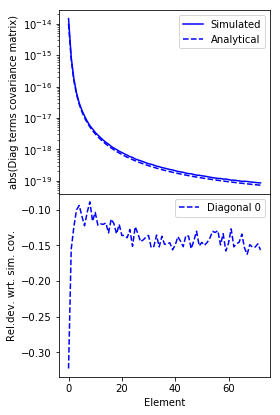

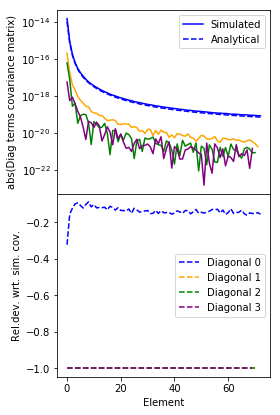

Chi2 distribution check


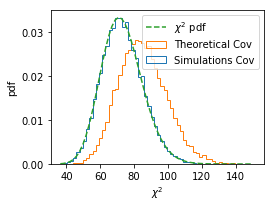

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.34705, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.005277688190870766, pvalue=0.6332676026783453)
KS between th. and chi2 distributions:  KstestResult(statistic=0.3486320031714574, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.004646030022588621, pvalue=0.7810161214037864)

Difference between analytic and sims. correlation matrix


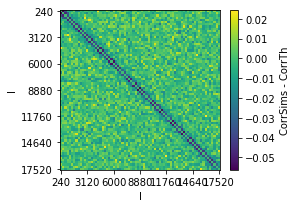

Eigenvalues vs l


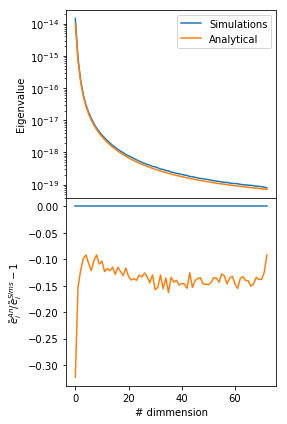

Row of cov. matrix.


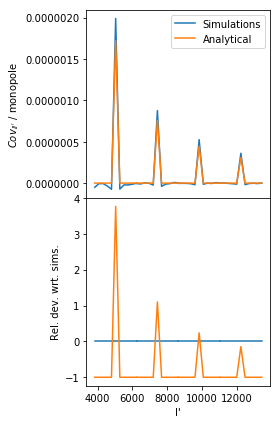

In [36]:
chi2N_TTTT, corr2N_TTTT = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TT[:lmax, :lmax], CovThN_TT[:lmax, :lmax],
                                           modes="TTTT", foutput=foutput + '_TTTT')

Checks for TTTT
Diagonal covariance matrix


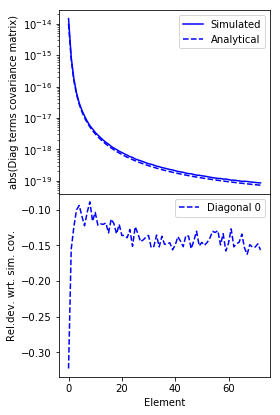

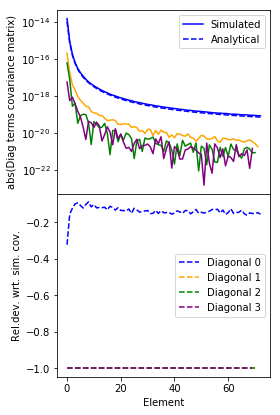

Chi2 distribution check


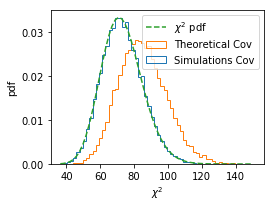

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.34705, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.005277688190870766, pvalue=0.6332676026783453)
KS between th. and chi2 distributions:  KstestResult(statistic=0.3486320031714574, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.006660993962812611, pvalue=0.3373988173031579)

Difference between analytic and sims. correlation matrix


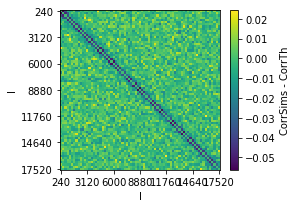

Eigenvalues vs l


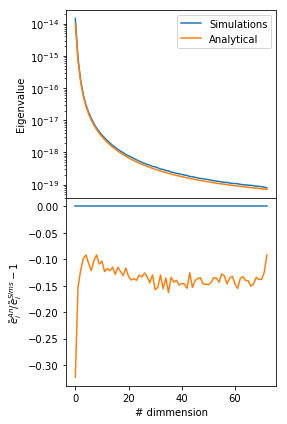

Row of cov. matrix.


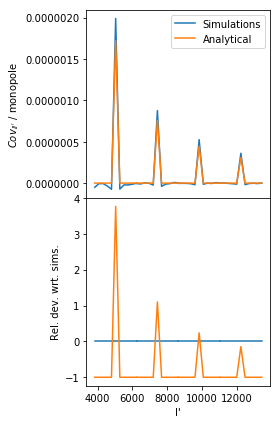

In [37]:
chi2N_TTTT, corr2N_TTTT = co.do_all_checks(lbins[:lmax], clTT[:, :lmax], CovSims_TT[:lmax, :lmax], CovThN_TT[:lmax, :lmax], modes="TTTT")

## TETE

Checks for TETE
Diagonal covariance matrix


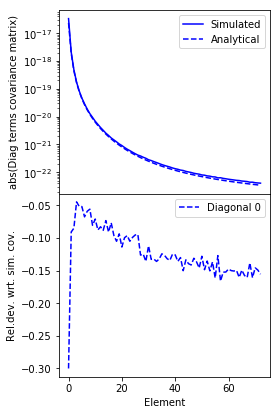

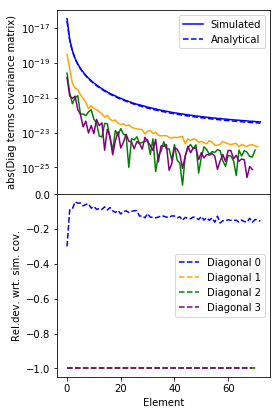

Chi2 distribution check


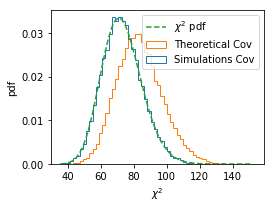

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.31495000000000006, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004147378353762887, pvalue=0.8816027037904001)
KS between th. and chi2 distributions:  KstestResult(statistic=0.31200863288559655, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.012281782853752032, pvalue=0.004793279549954894)

Difference between analytic and sims. correlation matrix


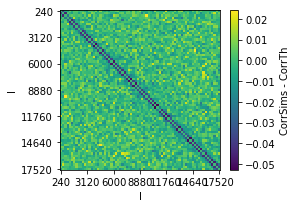

Eigenvalues vs l


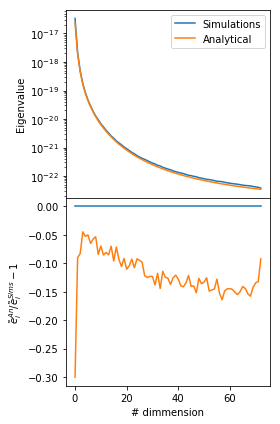

Row of cov. matrix.


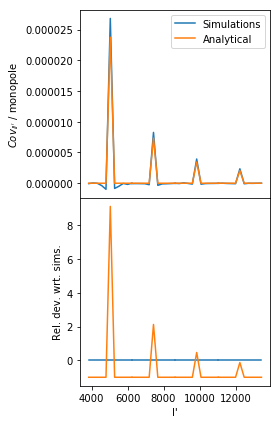

In [38]:
chi2N_TETE, corrN_TETE = co.do_all_checks(lbins[:lmax], clTE[:, :lmax], CovSims_TE[:lmax, :lmax], CovThN_TE[:lmax, :lmax],
                                          modes="TETE", foutput=foutput + '_TETE')

## EEEE

Checks for EEEE
Diagonal covariance matrix


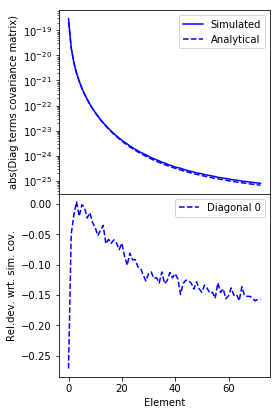

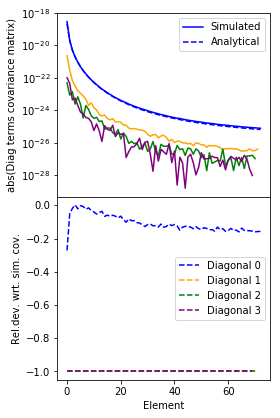

Chi2 distribution check


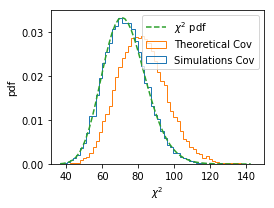

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.27860000000000007, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0057857890668666645, pvalue=0.514780560481503)
KS between th. and chi2 distributions:  KstestResult(statistic=0.27937136465367973, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.005355966697678516, pvalue=0.6146432526422239)

Difference between analytic and sims. correlation matrix


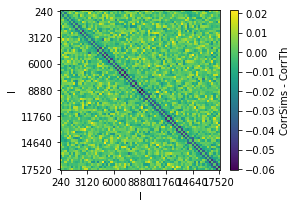

Eigenvalues vs l


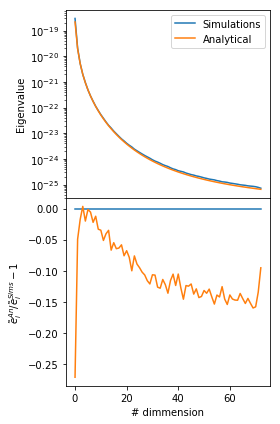

Row of cov. matrix.


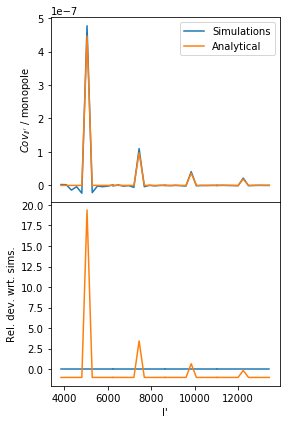

In [39]:
chi2N_EEEE, corrN_EEEE = co.do_all_checks(lbins[:lmax], clEE[:, :lmax], CovSims_EE[:lmax, :lmax], CovThN_EE[:lmax, :lmax],
                                          modes="EEEE", foutput=foutput + '_EEEE')

## BBBB

Checks for BBBB
Diagonal covariance matrix


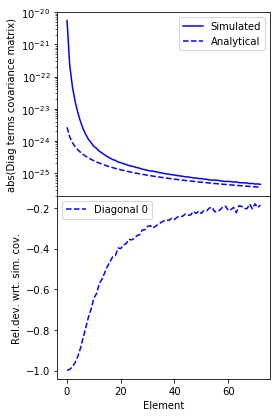

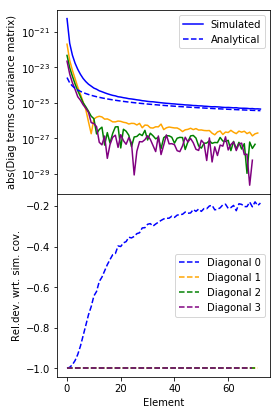

Chi2 distribution check


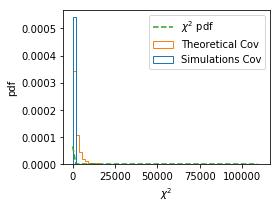

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.99875, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.006850539350129137, pvalue=0.30494086300747525)
KS between th. and chi2 distributions:  KstestResult(statistic=0.9988351152162578, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.0052855038555780776, pvalue=0.6314054754206466)

Difference between analytic and sims. correlation matrix


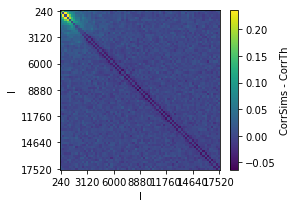

Eigenvalues vs l


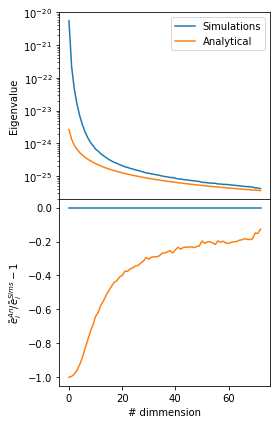

Row of cov. matrix.


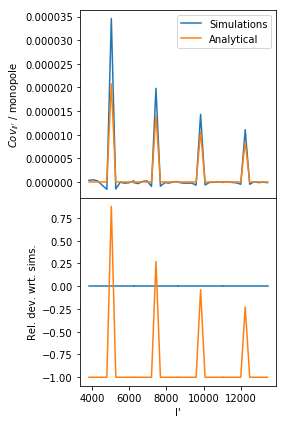

In [40]:
chi2N_BBBB, corrN_BBBB = co.do_all_checks(lbins[:lmax], clBB[:, :lmax], CovSims_BB[:lmax, :lmax], CovThN_BB[:lmax, :lmax],
                                          modes="BBBB", foutput=foutput + '_BBBB')

## TBTB

Checks for TBTB
Diagonal covariance matrix


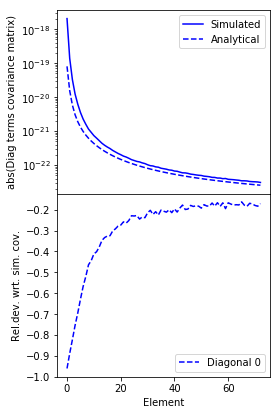

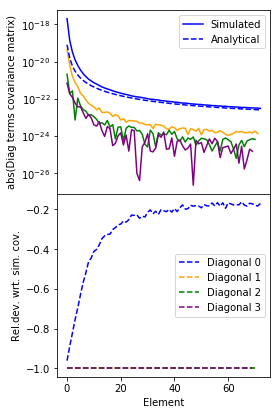

Chi2 distribution check


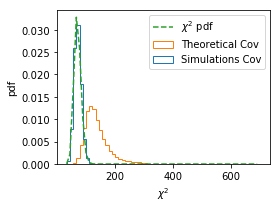

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.8703, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0041333214150549025, pvalue=0.8840676131235339)
KS between th. and chi2 distributions:  KstestResult(statistic=0.8691722699324268, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.003868102695267217, pvalue=0.9257660315061739)

Difference between analytic and sims. correlation matrix


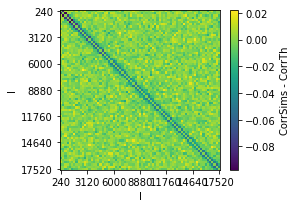

Eigenvalues vs l


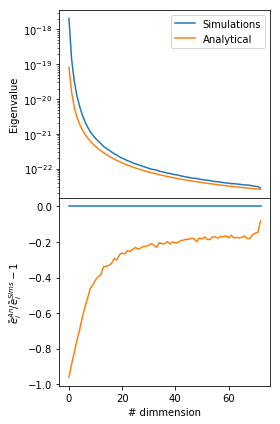

Row of cov. matrix.


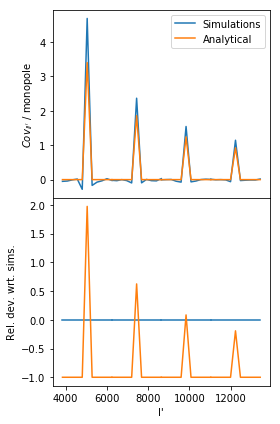

In [41]:
chi2N_TBTB, corr_TBTB = co.do_all_checks(lbins[:lmax], clTB[:, :lmax], CovSims_TB[:lmax, :lmax], CovThN_TB[:lmax, :lmax],
                                         modes="TBTB", foutput=foutput + '_TBTB')

## EBEB

Checks for EBEB
Diagonal covariance matrix


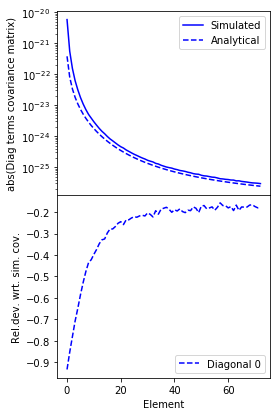

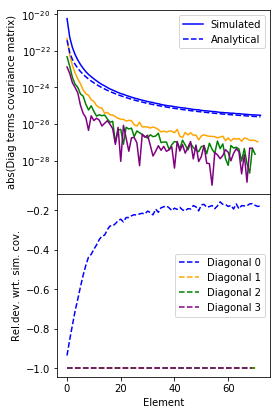

Chi2 distribution check


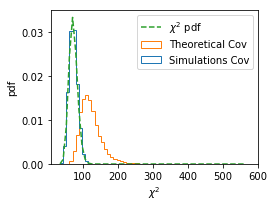

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.8089500000000001, pvalue=0.0)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.0058138795748926, pvalue=0.5084707606792822)
KS between th. and chi2 distributions:  KstestResult(statistic=0.8118582906111258, pvalue=0.0)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.01102423574017064, pvalue=0.015480033769620635)

Difference between analytic and sims. correlation matrix


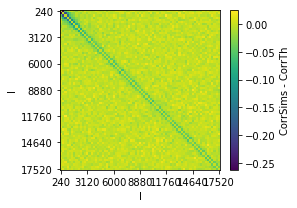

Eigenvalues vs l


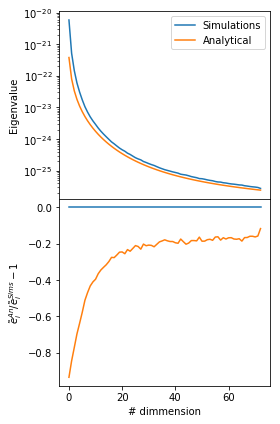

Row of cov. matrix.


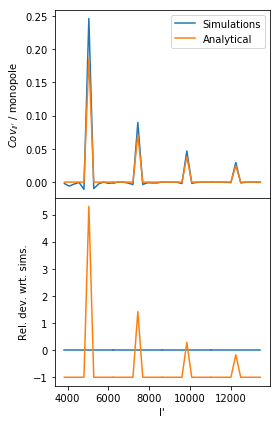

In [42]:
chi2N_EBEB, corrN_EBEB = co.do_all_checks(lbins[:lmax], clEB[:, :lmax], CovSims_EB[:lmax, :lmax], CovThN_EB[:lmax, :lmax],
                                          modes="EBEB", foutput=foutput + '_EBEB')

# Comparing the approximations

In [43]:
foutput = fig_run_path + '_ALL'

## Diagonal & eigenvalues & row cov

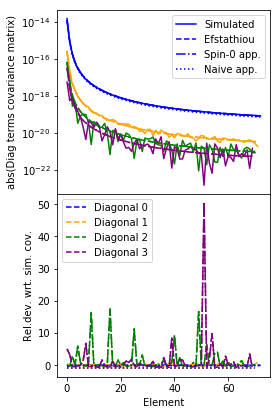

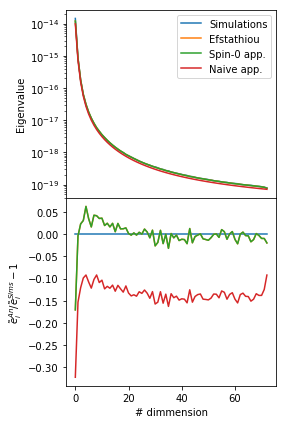

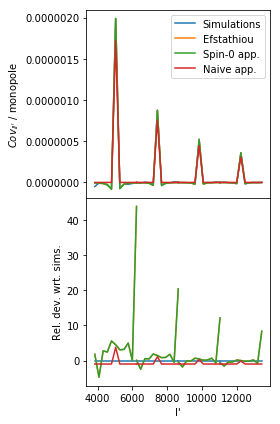

In [44]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_TT[:lmax,:lmax], [CovTh_TT[:lmax,:lmax], CovTh0_TT[:lmax,:lmax], CovThN_TT[:lmax,:lmax]],
                             ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTT,axis=0)[0]**2,
                             principal=False, foutput=foutput + '_TTTT')

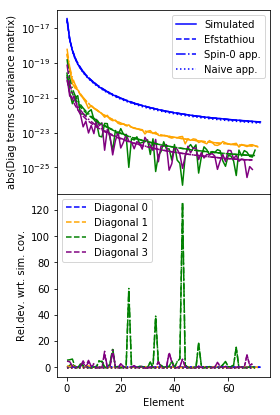

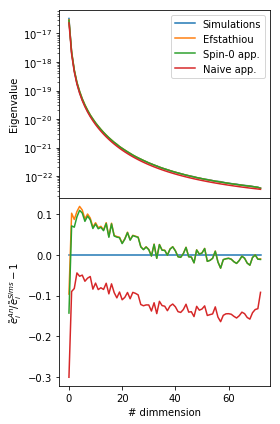

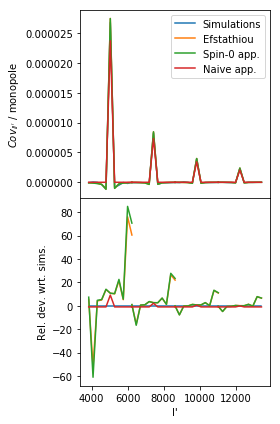

In [45]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_TE[:lmax,:lmax], [CovTh_TE[:lmax,:lmax], CovTh0_TE[:lmax,:lmax], CovThN_TE[:lmax,:lmax]],
                             ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTE,axis=0)[0]**2,
                             foutput=foutput + '_TETE')

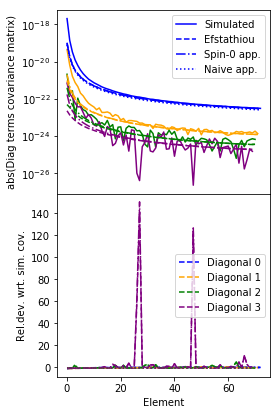

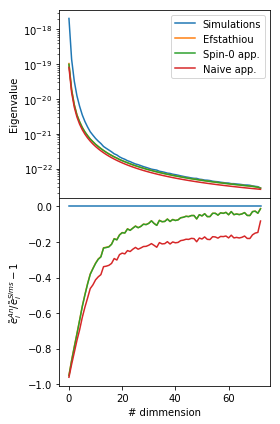

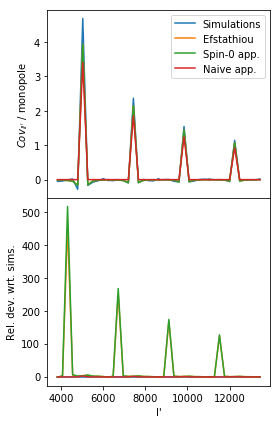

In [46]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_TB[:lmax,:lmax], [CovTh_TB[:lmax,:lmax], CovTh0_TB[:lmax,:lmax], CovThN_TB[:lmax,:lmax]],
                             ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTB, axis=0)[0]**2,
                             foutput=foutput + '_TBTB')

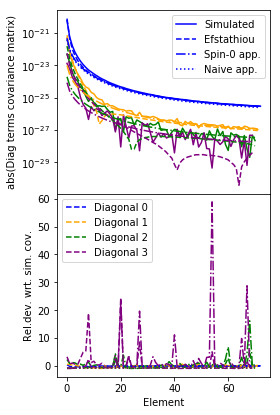

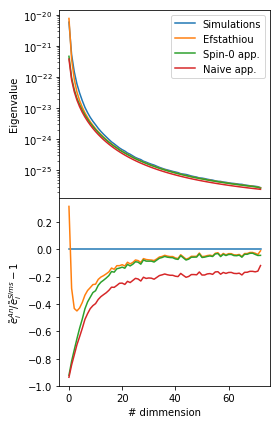

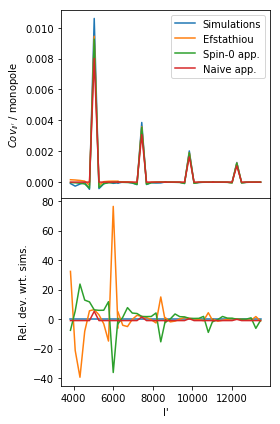

In [47]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_EB[:lmax,:lmax], [CovTh_EB[:lmax,:lmax], CovTh0_EB[:lmax,:lmax], CovThN_EB[:lmax,:lmax]],
                             ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clTB,axis=0)[0]**2,
                             foutput=foutput + '_EBEB')

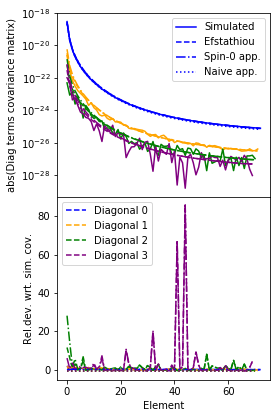

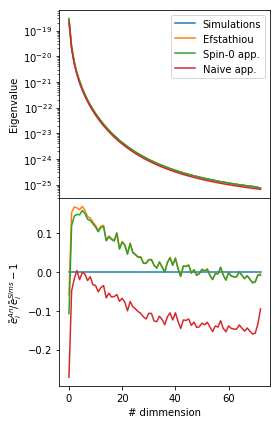

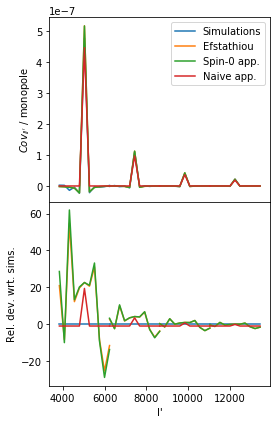

In [48]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_EE[:lmax,:lmax], [CovTh_EE[:lmax,:lmax], CovTh0_EE[:lmax,:lmax], CovThN_EE[:lmax,:lmax]], 
                             ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clEE,axis=0)[0]**2,
                            foutput=foutput + '_EEEE')

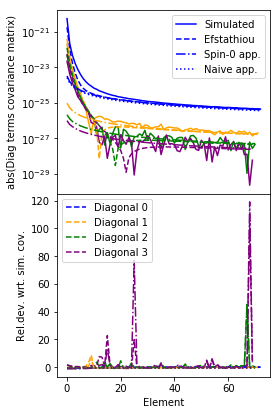

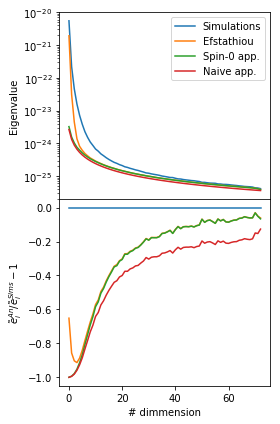

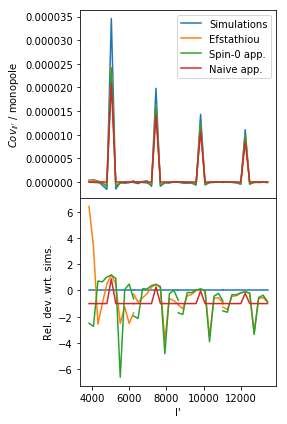

In [49]:
co.do_check_covariance_terms(lbins[:lmax], CovSims_BB[:lmax,:lmax], [CovTh_BB[:lmax,:lmax], CovTh0_BB[:lmax,:lmax], CovThN_BB[:lmax,:lmax]],
                             ['Efstathiou', 'Spin-0 app.', 'Naive app.'], normalization_rows=np.mean(clBB,axis=0)[0]**2,
                             principal=False, foutput=foutput + '_BBBB')

## $\chi^2$

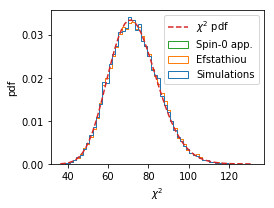

In [50]:
co.plot_chi2([chi2_TTTT[0], chi2_TTTT[1], chi20_TTTT[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_TTTT')

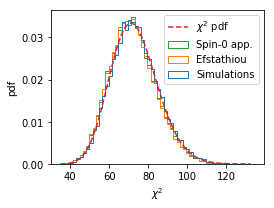

In [51]:
co.plot_chi2([chi2_TETE[0], chi2_TETE[1], chi20_TETE[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_TETE')

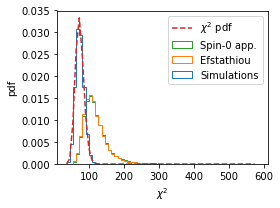

In [52]:
co.plot_chi2([chi2_TBTB[0], chi2_TBTB[1], chi20_TBTB[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_TBTB')

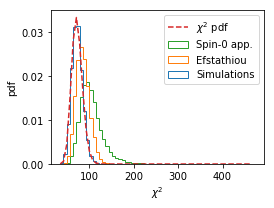

In [53]:
co.plot_chi2([chi2_EBEB[0], chi2_EBEB[1], chi20_EBEB[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_EBEB')

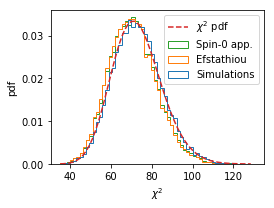

In [54]:
co.plot_chi2([chi2_EEEE[0], chi2_EEEE[1], chi20_EEEE[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_EEEE')

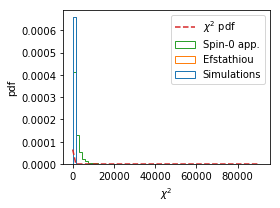

In [55]:
co.plot_chi2([chi2_BBBB[0], chi2_BBBB[1], chi20_BBBB[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_BBBB')

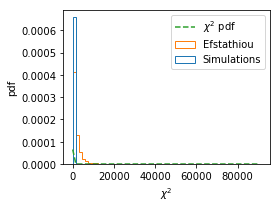

In [56]:
co.plot_chi2([chi2_BBBB[0], chi20_BBBB[1]], lmax=lmax,
             labels=['Simulations', 'Efstathiou', 'Spin-0 app.', 'Naive app.'],
             foutput=foutput + '_BBBB')

## Covariance rows

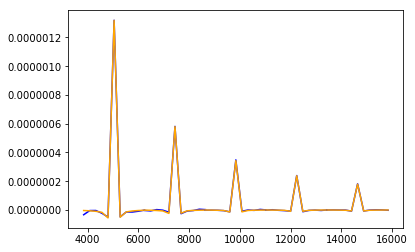

In [57]:
li = 20
for i in range(5):
    X = lbins[:lmax][li-5:li+6]
    #Y = CovSims_TT[li, li-5:li+5]/clTT[0, li-5:li+5]**2
    Y = CovSims_TT[:lmax,:lmax][li, li-5:li+6]/clTT[0, 0]**2
    Yth = CovTh_TT[:lmax,:lmax][li, li-5:li+6]/clTT[0, 0]**2

    li += 2*5

    plt.plot(X, Y, c='blue')
    plt.plot(X, Yth, c='orange')
    
plt.show()
plt.close()

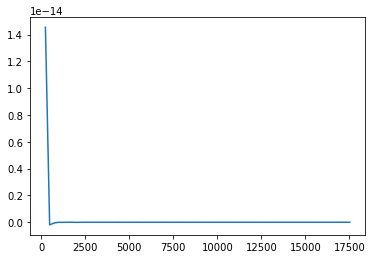

In [58]:
plt.plot(lbins, CovSims_TT[0])
plt.show()

# Super Cov-TTEEEE

In [59]:
foutput = fig_run_path + '_Efstathiou'

In [60]:
CovSims_TTTEEE_short =  np.block([[CovSims_TT[:lmax, :lmax], CovSims_TTTE[:lmax, :lmax], CovSims_TTEE[:lmax, :lmax]], 
                        [CovSims_TTTE.T[:lmax, :lmax], CovSims_TE[:lmax, :lmax], CovSims_TEEE[:lmax, :lmax]], 
                        [CovSims_TTEE.T[:lmax, :lmax], CovSims_TEEE.T[:lmax, :lmax], CovSims_EE[:lmax, :lmax]]])
CovTh_TTTEEE_short =  np.block([[CovTh_TT[:lmax, :lmax], CovTh_TTTE[:lmax, :lmax], CovTh_TTEE[:lmax, :lmax]], 
                        [CovTh_TTTE.T[:lmax, :lmax], CovTh_TE[:lmax, :lmax], CovTh_TEEE[:lmax, :lmax]], 
                        [CovTh_TTEE.T[:lmax, :lmax], CovTh_TEEE.T[:lmax, :lmax], CovTh_EE[:lmax, :lmax]]])
clTTTEEE = np.concatenate([clTT[:, :lmax], clTE[:, :lmax], clEE[:, :lmax]], axis=1)
lbinsTTTEEE = np.concatenate([lbins[:lmax]]*3)

Checks for TTTTEEE
Diagonal covariance matrix


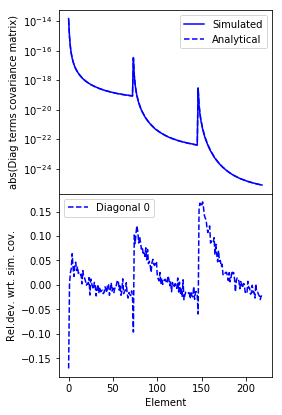

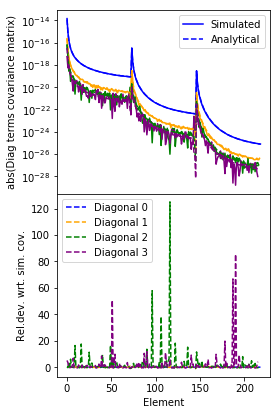

Chi2 distribution check


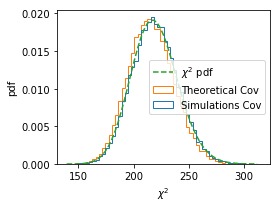

KS between sim. and th. distributions:  Ks_2sampResult(statistic=0.06805, pvalue=9.57000853040216e-41)
KS between sim. and chi2 distributions:  KstestResult(statistic=0.004005941635012472, pvalue=0.9052690854752241)
KS between th. and chi2 distributions:  KstestResult(statistic=0.06616723868788676, pvalue=1.7602841148542083e-76)
KS between sampled_chi2 and chi2 distributions:  KstestResult(statistic=0.006586752997542522, pvalue=0.3507218482277027)

Difference between analytic and sims. correlation matrix


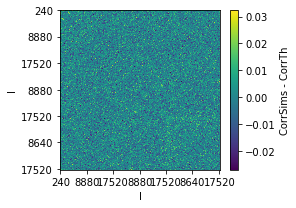

Eigenvalues vs l


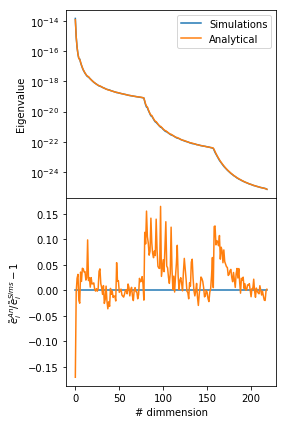

In [61]:
chi2_TTTEEE, corr_TTTEEE = co.do_all_checks(lbinsTTTEEE, clTTTEEE, CovSims_TTTEEE_short, CovTh_TTTEEE_short,
                                            modes="TTTTEEE", row_cov=False,
                                            foutput=foutput + '_TTTEEE')